complete data likelihood:

\begin{aligned}
p(\mathbf{Z}, \mathbf{X}, \mathbf{H}, \mathbf{Y} | \Theta) &=\prod_{i=1}^{N} P\left(\mathbf{z}_{i}\right) p\left(\mathbf{x}_{i} | \mathbf{z}_{i}\right) p\left(\mathbf{h}_{i} | \mathbf{x}_{i}\right) p\left(\mathbf{y}_{i} | \mathbf{h}_{i}, \mathbf{x}_{i}\right) \\
&=\prod_{i=1}^{N}\left[p\left(\mathbf{z}_{i}\right) \prod_{j=1}^{p} p\left(x_{i j} | \mathbf{z}_{i}\right) p\left(h_{i j} | x_{i j}\right) p\left(y_{i j} | x_{i j}, h_{i j}\right)\right] \\
&=\prod_{i=1}^{N}\left[p\left(\mathbf{z}_{i}\right) \prod_{j: y_{i j}=0} p\left(x_{i j} | \mathbf{z}_{i}\right) p\left(h_{i j}=1 | x_{i j}\right) \prod_{j: y_{i j} \neq 0} p\left(x_{i j}=y_{i j} | \mathbf{z}_{i}\right) p\left(h_{i j}=0 | x_{i j}\right)\right]
\end{aligned}

complete data log likelihood:

\begin{aligned}
\ln p(\mathbf{Z}, \mathbf{X}, \mathbf{H}, \mathbf{Y} | \Theta) & \propto-\frac{1}{2} \sum_{i=1}^{N} \mathbf{z}_{i}^{T} \mathbf{z}_{i} \\
&+\sum_{i=1}^{N}\left[\sum_{j: y_{i j}=0}\left\{-\frac{\left(x_{i j}-\left(\mathbf{A_j} \mathbf{z}_{i}+\boldsymbol{\mu_j}\right)\right)^{2}}{2 \sigma_{j}^{2}}- \ln \sigma_{j}-\lambda x_{i j}^{2}\right\}\right] \\
&+\sum_{i=1}^{N}\left[\sum_{j: y_{i j}=0}\left\{-\frac{\left(y_{i j}-\left(\mathbf{A_j} \mathbf{z}_{i}+\boldsymbol{\mu_j}\right)\right)^{2}}{2 \sigma_{j}^{2}}- \ln \sigma_{j}+\ln \left(1-\exp \left(-\lambda y_{i j}^{2}\right)\right)\right\}\right]
\end{aligned}

$p(z_i,x_{i0}|y_i)$ with mean

$$
\left(\boldsymbol{\Sigma}_{c}^{-1}+2 \lambda \mathbf{I}_{x}\right)^{-1}
\boldsymbol{\Sigma}_{c}^{-1} \boldsymbol{\mu}_{c}
$$

and variance

$$\left(\boldsymbol{\Sigma}_{c}^{-1}+2 \lambda \mathbf{I}_{x}\right)^{-1}$$

M-step:
A, $\mu$, W have analytic solution while $\lambda$ needs numerical method to approach

$$\mu_{j}=\frac{1}{N}\left[\sum_{i: y_{i j}=0}\left(E\left[x_{i j}\right]-\sum_{k=1}^{K} a_{j k} E\left[z_{i k}\right]\right)+\sum_{i: y_{i j}>0}\left(y_{i j}-\sum_{k=1}^{K} a_{j k} E\left[z_{i k}\right]\right)\right]$$

\begin{aligned}
{a_{j k}=\frac{1}{\sum_{i=1}^{N} E\left[z_{i k}^{2}\right]}\left[\sum_{i: y_{i j}=0}\left(E\left[x_{i j} z_{i k}\right]-\mu_{j} E\left[z_{i k}\right]-\sum_{k^{\prime} \neq k} a_{j k^{\prime}} E\left[z_{i k} z_{i k^{\prime}}\right]\right)+\right.}\\{\left.\sum_{i: y_{i j}>0}\left(Y_{i j} E\left[z_{i k}\right]-\mu_{j} E\left[z_{i k}\right]-\sum_{k^{\prime} \neq k} a_{j k^{\prime}} E\left[z_{i k} z_{i k^{\prime}}\right]\right)\right]}
\end{aligned}

$$
\sigma^{2}=\frac{1}{N D} \sum_{j}\left(\sum_{i: y_{i j}=0}\left(E\left[x_{i j}^{2}\right]-2 E\left[x_{i j} m_{i j}\right]+E\left[m_{i j}^{2}\right]\right)+\sum_{i: y_{i j}>0}\left(y_{i j}^{2}-2 y_{i j} E\left[m_{i j}\right]+E\left[m_{i j}^{2}\right]\right)\right)
$$

The derivation is so challenging that I refer to the supplementary information of paper, and I go through the whole logic and all equations in my implementation. There are some mistakes in the supplementary information and some obvious ones recognized by me is being revised in my implementation, while there might be others that I have not noticed. Also, there are many details that I have not thought about so that there are still distance between my implementation and the official one.

In [1]:
import numpy as np
from copy import deepcopy as dcpy
from sklearn.decomposition import FactorAnalysis
eps = 1e-7

In [2]:
# quick print and check the shape of matrix to debug
def prt(str, X):
    print(str, X.shape)

In [3]:
def E_step(Y, A, MU, W, _lambda):
    omega = (Y > eps).astype(int)
    N, D = Y.shape
    K = A.shape[1]
    
    #Initialization: an easy way to determine the dimension is the different indexs in one term
    EZ = np.zeros([N, K])
    EX = np.zeros([N, D])
    EX2 = np.zeros([N, D])
    EXZ = np.zeros([N, D, K])
    EZZT = np.zeros([N, K, K])
    
    # prior distribution p(zi, xi) is a multivariate normal
    prior_dim = K + D
    prior_mean = np.zeros(prior_dim)
    prior_mean[K: prior_dim] = dcpy(MU)
    prior_covar = np.zeros((prior_dim, prior_dim))
    prior_covar[:K, :K] = np.identity(K)
    prior_covar[K:, :K] = dcpy(A)
    prior_covar[:K, K:] = dcpy(A.T)
    prior_covar[K:, K:] = A @ A.T + W
    for i in range(N):
        # separate indexs into two parts by the corresponding value
        zero_idx = np.squeeze(np.array(np.nonzero(1-omega[i])))
        pos_idx = np.squeeze(np.array(np.nonzero(omega[i])))
        # the return value of np.nonzero() is in the format of tuple, which needs transformation
        #prt('pos_idx', pos_idx)
        
        # auxiliary variables for mu_c and sigma_c
        mu_0 = prior_mean[zero_idx]
        mu_p = prior_mean[pos_idx]
        yi_p = Y[i][pos_idx]
        
        row_zero = prior_covar[zero_idx]
        row_pos = prior_covar[pos_idx]
        sigma_00 = row_zero[:, zero_idx]
        sigma_0p = row_zero[:, pos_idx]
        sigma_p0 = row_pos[:, zero_idx]
        sigma_pp = row_pos[:, pos_idx]
        
        # calculate mu_c and sigma_c
        mu_c = mu_0 + sigma_0p @ np.linalg.inv(sigma_pp) @ (yi_p - mu_p)
        sigma_c = sigma_00 - sigma_0p @ np.linalg.inv(sigma_pp) @ sigma_p0
        
        # p(zi, xi0|yi) is also is a multivariate normal distribution
        post_mean_XZ = np.linalg.inv( np.identity(len(zero_idx)) + 2*_lambda*sigma_c ) @ mu_c
        post_covar_XZ = np.linalg.inv( np.linalg.inv(sigma_c) + 2*_lambda*np.identity(len(zero_idx)) )
        
        prt('EX', EZ)
        prt('post_mean_XZ', post_mean_XZ)
        
        EZ[i, :] = post_mean_XZ[:K, 0]
        EX[i, zero_idx] = post_mean_XZ[K:, 0]
        EX2[i, zero_idx] = post_mean_XZ[K:, 0]**2 + np.diag(post_var[K:, K:])
        EXZ[i, zero_idx, :] = post_mean_XZ[K:], post_mean_XZ[:K].T + post_covar_XZ[K:, :K]
        EZZT[i, :, :] = post_mean_XZ[:K, :] @ post_mean_XZ[:K, :].T + post_covar_XZ[:K, :K]
        
        return EZ, EX, EX2, EXZ, EZZT

In [4]:
def func(x, Y, EX2):
    y_squared = Y ** 2
    Y_is_zero = np.abs(Y) < 1e-6
    exp_Y_squared = np.exp(-x * y_squared)
    log_exp_Y = np.nan_to_num(np.log(1 - exp_Y_squared))
    exp_ratio = np.nan_to_num(exp_Y_squared / (1 - exp_Y_squared))
    obj = sum(sum(Y_is_zero * (-EX2 * x) + (1 - Y_is_zero) * log_exp_Y))
    grad = sum(sum(Y_is_zero * (-EX2) + (1 - Y_is_zero) * y_squared * exp_ratio))
    
    return obj, grad

In [5]:
def M_step(Y, A_old, MU_old, W_old, _lambda_old, EZ, EX, EX2, EXZ, EZZT, ):
    omega = (Y > eps).astype(int)
    N, D = Y.shape
    K = A_old.shape[1]
    
    # A, MU, W have analytic solution while _lambda needs numerical method
    
    B = np.zeros((K+1, K+1)) # B: same for all j
    for k1 in range(K):
        for k2 in range(K):
            # calculate K*K submatrix
            B[k1][k2] = sum(EZZT[:, k1, k2])
    B[K, :K] = EZ.sum(axis=0) # last row
    B[:K, K] = EZ.sum(axis=0) # last column
    B[K, K] = N # last component
            
    # all denominators are eliminated together for each line in B and c
    
    c = np.zeros((K+1, D)) 
    for k in range(K):
        for j in range(D):
            for i in range(N):
                if omega[i][j]:
                    c[k][j] = c[k][j] + Y[i][j] * EZ[i][k]
                else:
                    c[k][j] = c[k][j] + EXZ[i][j][k]
    # try to get rid of bugs using elementwise operation
    for j in range(D):
        for i in range(N):
            if Y[i][j]:
                c[K][j] = c[K][j] + Y[i][j]
            else:
                c[K][j] = c[K][j] + EX[i][j]
    
    u = np.linalg.inv(B) @ c
    A = u[:K, :].T
    MU = np.atleast_2d(u[K, :]).T
    
    # m_ij = sigma_k A_jk*Z_jk +mu_j
    EXM = np.zeros((N, D))
    EM = np.zeros((N, D))
    EM2 = np.zeros((N, D))
    
    A_product = np.tile(np.reshape(A, [1, D, K]), [K, 1, 1]) * (np.tile(np.reshape(A, [1, D, K]), [K, 1, 1]).T)
    tiled_A = np.tile(np.resize(A, [1, D, K]), [N, 1, 1])
    tiled_EZ = np.tile(np.resize(EZ, [N, 1, K]), [1, D, 1])
    test_sum = (tiled_A * tiled_EZ).sum(axis=2)
    tiled_mus = np.tile(MU.T, [N, 1])
    
    for i in range(N):
        EXM[i, :] = A * EXZ[i].sum(axis=2) + MU * EX[i]
        EM[i, :] = A @ EZ[i, :].T + MU.T
        
        EZZT_tiled = np.tile(np.reshape(EZZT[i, :, :], [K, 1, K]), [1, D, 1])
        ezzt_sum = (EZZT_tiled * A_product).sum(axis=2).sum(axis=0)
        EM2[i, :] = ezzt_sum + 2 * test_sum[i, :] * tiled_mus[i, :] + tiled_mus[i, :] ** 2
    
    W = ((1-omega) * (EX2 - 2*EXM + EM2) + omega * (Y**2 - 2*Y*EM + EM2)).sum(axis=0)
    W = 1.0 * W / N / D
    
    coef = minimize(lambda x: func(x, Y, EX2), _lambda_old, jac=True, bounds=[[eps, np.inf]])
    _lambda = coef.x[0]
    
    return A, MU, W, _lambda

In [6]:
def E_M(Y, K):
    '''
    Y: observed data, (N, D)
    K: dimension of latent space, e.g., l = 10
    '''
    # Initialize parameter(A, MU, W, _lambda)
    N, D = Y.shape
    #FA = FactorAnalysis(K)
    A = np.random.rand(D, K)
    MU = np.random.rand(D)
    W = np.random.rand(D, D)
    _lambda = np.random.rand()
    
    it = 0
    maxiter = 100
    while it < maxiter:
        it = it+1
        
        EZ, EZ2, EX, EX2, EZZT, EXZ = E_step(Y, A, MU, W, _lambda)
        A, MU, W, _lambda = M_step(Y, A, MU, W, _lambda, EZ, EZ2, EX, EX2, EZZT, EXZ)

In [7]:
# Simulation study(set up same as paper)
N = 150
K = 10
D = 50
sigma2 = 0.3
_lambda = 0.1
# parameter
A = np.random.uniform(-0.5, 0.5, (D, K))
MU = np.random.uniform(2.7, 3.3, D)
W = np.random.uniform(0.9, 1.1, D) * sigma2
#latent variable
Z = np.random.normal(0, 1, (N, K))
X = np.zeros((N, D))
for i in range(N):
    X[i, :] = np.random.normal(A @ Z[i, :] + MU, np.sqrt(W))
P = np.exp(-_lambda * X**2)
H = np.random.binomial(n=1, p=P, size = (N, D))
Y = X * H
print('Dropout rate:', 1 - H.sum()/N/D)

Dropout rate: 0.5589333333333333


In [8]:
#E_M(Y, K) #bugs unfixed

Running zero-inflated factor analysis with N = 3005, D = 558, K = 10
Param change below threshold 1.000e-02 after 5 iterations


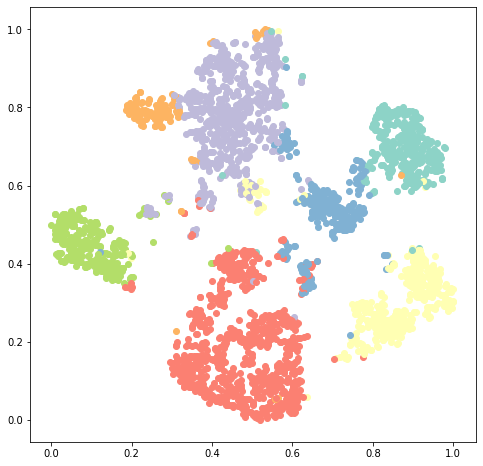

In [9]:
import ZIFA
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = pd.read_csv('gene_expression.txt', sep = ' ', header = None)
Y = data.values
#print(Y.shape)

EZ, paras = ZIFA.fitModel(Y, K = 10)

kmeans = KMeans(n_clusters=7)
kmeans.fit_predict(EZ)
label_pred = kmeans.labels_

tsne = TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(EZ)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
    
plt.figure(figsize=(8, 8))
for i in range(len(X_norm)):
    plt.scatter(float(X_norm[i, 0]), float(X_norm[i, 1]), color=plt.cm.Set3(label_pred[i]))
fig = plt.show()
